In [7]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("/content/transactions_train.csv")

# Show the first few rows
print("Initial data snapshot:")
print(df.head())

# Convert transaction_date to datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Normalize transaction_channel (e.g., 'W', 'w' → 'web')
df['transaction_channel'] = df['transaction_channel'].str.lower().replace({'w': 'web'})

# Clean 'payer_mobile_anonymous'
df['payer_mobile_anonymous'] = df['payer_mobile_anonymous'].replace('XXXXX', np.nan)
df['payer_mobile_anonymous'] = df['payer_mobile_anonymous'].replace(r'XXXXX.*', np.nan, regex=True)

# Impute missing values

## 1. For payer_mobile_anonymous (categorical/anonymized)
df['payer_mobile_anonymous'].fillna('Unknown', inplace=True)

## 2. For transaction_channel (categorical)
df['transaction_channel'].fillna(df['transaction_channel'].mode()[0], inplace=True)

## 3. For numeric columns (if any)
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Reset index after cleanup
df.reset_index(drop=True, inplace=True)

# Final snapshot
print("\nCleaned data snapshot:")
print(df.head())


Initial data snapshot:
   transaction_amount     transaction_date transaction_channel  is_fraud  \
0              3606.0  2024-11-01 00:00:06                   w         0   
1               599.0  2024-11-01 00:00:08              mobile         0   
2                30.0  2024-11-01 00:00:12                   w         0   
3                99.0  2024-11-01 00:00:34              mobile         0   
4               299.0  2024-11-01 00:01:23              mobile         0   

   transaction_payment_mode_anonymous  payment_gateway_bank_anonymous  \
0                                  10                               0   
1                                  10                               6   
2                                  10                               0   
3                                  11                               0   
4                                  11                               0   

   payer_browser_anonymous                              payer_email_anonymous  \


<ipython-input-7-e962676b45a8>:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['payer_mobile_anonymous'] = df['payer_mobile_anonymous'].replace(r'XXXXX.*', np.nan, regex=True)
<ipython-input-7-e962676b45a8>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['payer_mobile_anonymous'].fillna('U

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Set nice colors and grid style
sns.set_palette('Set2')
sns.set_style("whitegrid")


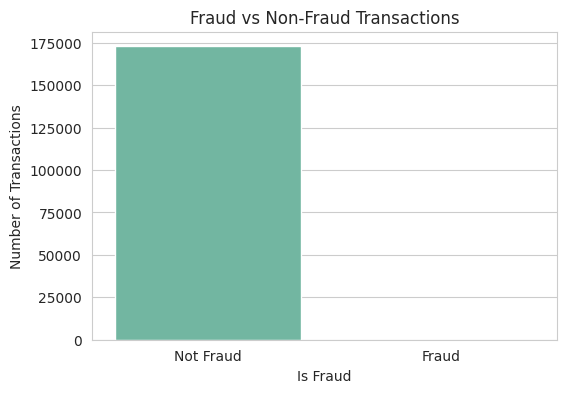

Fraud Distribution:
is_fraud
0    172915
1        11
Name: count, dtype: int64


In [11]:
# Count of fraud vs non-fraud
fraud_counts = df['is_fraud'].value_counts()

plt.figure(figsize=(6,4))
sns.countplot(x='is_fraud', data=df)
plt.title("Fraud vs Non-Fraud Transactions")
plt.xlabel("Is Fraud")
plt.ylabel("Number of Transactions")
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.show()

print("Fraud Distribution:")
print(fraud_counts)


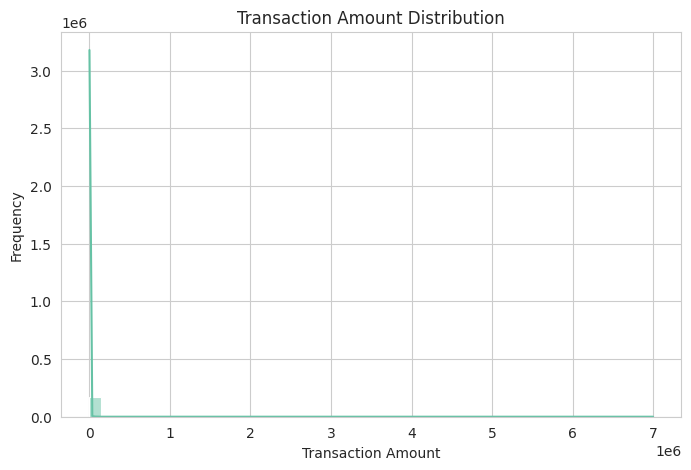

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(df['transaction_amount'], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()


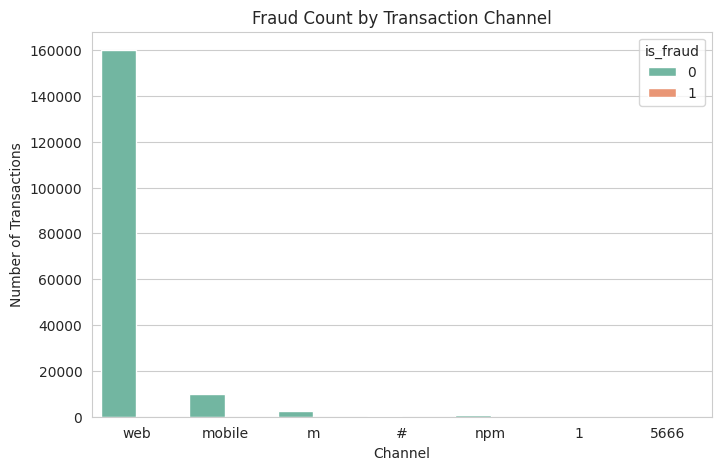

In [14]:
plt.figure(figsize=(8,5))
sns.countplot(x='transaction_channel', hue='is_fraud', data=df)
plt.title("Fraud Count by Transaction Channel")
plt.xlabel("Channel")
plt.ylabel("Number of Transactions")
plt.show()


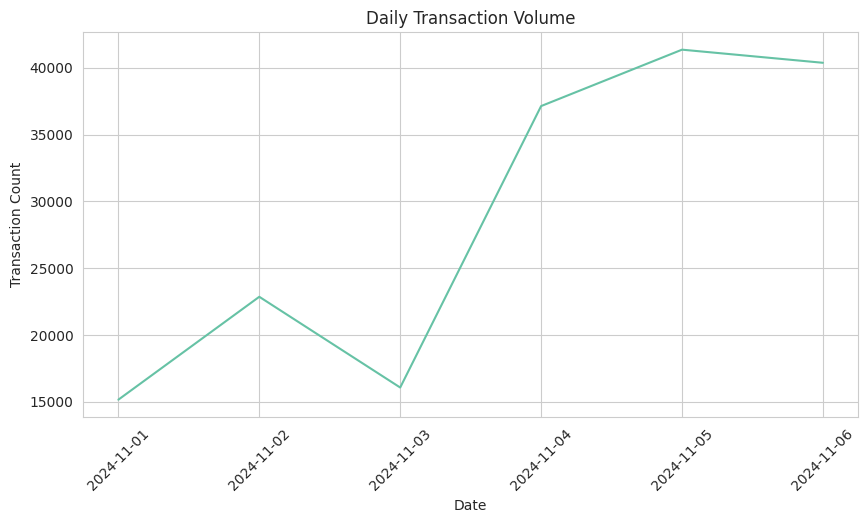

In [15]:
df['date_only'] = df['transaction_date'].dt.date

# Daily transaction volume
daily_counts = df.groupby('date_only')['transaction_id_anonymous'].count()

plt.figure(figsize=(10,5))
daily_counts.plot()
plt.title("Daily Transaction Volume")
plt.xlabel("Date")
plt.ylabel("Transaction Count")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


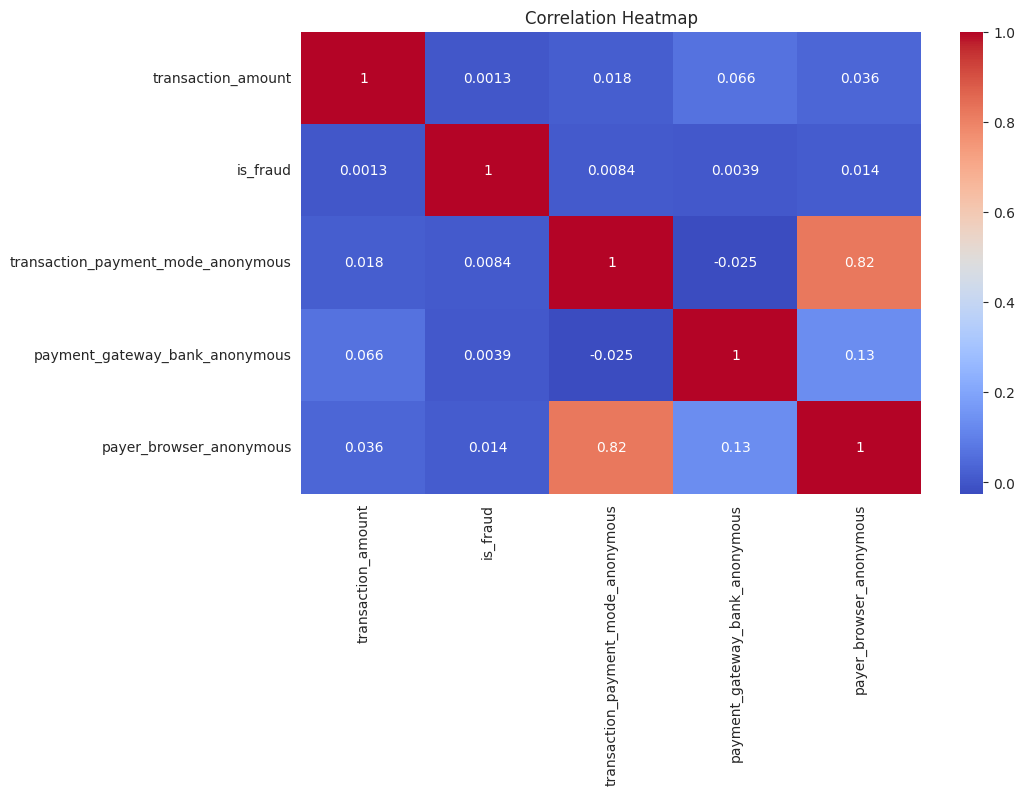

In [17]:
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


EDA on Only Fraudulent Transactions for building rule based system


In [24]:
# STEP 1: Extract fraud transactions
fraud_df = df[df['is_fraud'] == 1]

# Preview the fraud data
print(f"🔎 Total fraud transactions: {len(fraud_df)}")
fraud_df.head()


🔎 Total fraud transactions: 11


,transaction_amount,transaction_date,transaction_channel,is_fraud,transaction_payment_mode_anonymous,payment_gateway_bank_anonymous,payer_browser_anonymous,payer_email_anonymous,payee_ip_anonymous,payer_mobile_anonymous,transaction_id_anonymous,payee_id_anonymous,date_only
9629,2500.0,2024-11-01 16:08:12,mobile,1,10,6,1833,59d6b6631c5d1d78f9a95bbb5a6eea9af7dcadfaec526e...,773220d255be3b46b7bacc6ef9bc3174aeb7fa96208096...,Unknown,ANON_9629,ANON_47,2024-11-01
9764,799.0,2024-11-01 16:15:12,mobile,1,10,6,1833,59d6b6631c5d1d78f9a95bbb5a6eea9af7dcadfaec526e...,773220d255be3b46b7bacc6ef9bc3174aeb7fa96208096...,Unknown,ANON_9764,ANON_47,2024-11-01
27514,9338.0,2024-11-02 14:43:43,mobile,1,2,6,2766,e328fa76459a3035fa6de22fc37050e56f8215b2c5885b...,773220d255be3b46b7bacc6ef9bc3174aeb7fa96208096...,Unknown,ANON_27514,ANON_265,2024-11-02
41176,11749.0,2024-11-03 11:14:07,mobile,1,6,58,3378,9825cbfd00d1ad61d9c16bcc2f6b55b70ab788db08ec0b...,773220d255be3b46b7bacc6ef9bc3174aeb7fa96208096...,Unknown,ANON_41176,ANON_8,2024-11-03
66597,8999.0,2024-11-04 12:54:07,mobile,1,2,6,2766,75788c14ad5afec4a37148c534c48d0003f801d9938420...,773220d255be3b46b7bacc6ef9bc3174aeb7fa96208096...,Unknown,ANON_66597,ANON_265,2024-11-04


💰 Fraud Transaction Amount Stats:
count       11.000000
mean      6561.363636
std       7185.967760
min        300.000000
25%       2000.000000
50%       4000.000000
75%       9168.500000
max      24990.000000
Name: transaction_amount, dtype: float64


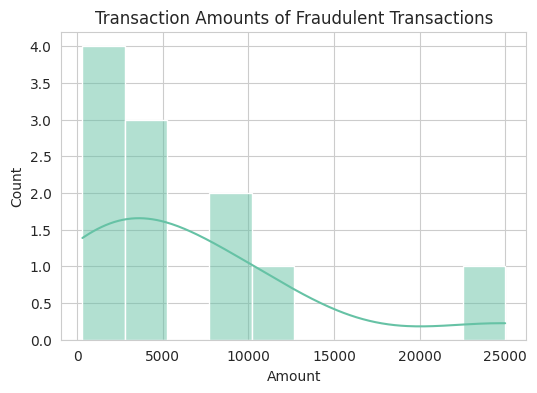

In [25]:
print("💰 Fraud Transaction Amount Stats:")
print(fraud_df['transaction_amount'].describe())

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.histplot(fraud_df['transaction_amount'], bins=10, kde=True)
plt.title("Transaction Amounts of Fraudulent Transactions")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.show()


In [26]:
print("📱 Fraud Transaction Channels:")
print(fraud_df['transaction_channel'].value_counts())


📱 Fraud Transaction Channels:
transaction_channel
mobile    6
web       5
Name: count, dtype: int64


In [27]:
print("🧾 Payment Modes in Fraud:")
print(fraud_df['transaction_payment_mode_anonymous'].value_counts())

print("🌐 Browser IDs in Fraud:")
print(fraud_df['payer_browser_anonymous'].value_counts())


🧾 Payment Modes in Fraud:
transaction_payment_mode_anonymous
10    7
2     3
6     1
Name: count, dtype: int64
🌐 Browser IDs in Fraud:
payer_browser_anonymous
3212    5
1833    2
2766    2
3378    1
2721    1
Name: count, dtype: int64


In [28]:
print("📬 Frequent Payee IDs:")
print(fraud_df['payee_id_anonymous'].value_counts().head())

print("📧 Frequent Payer Emails:")
print(fraud_df['payer_email_anonymous'].value_counts().head())


📬 Frequent Payee IDs:
payee_id_anonymous
ANON_12     5
ANON_265    3
ANON_47     2
ANON_8      1
Name: count, dtype: int64
📧 Frequent Payer Emails:
payer_email_anonymous
a8da55af67bc2d875e9fb7b0e887a3eb6e7d2ec5dc6171a0d4619da27c3d0da3    4
59d6b6631c5d1d78f9a95bbb5a6eea9af7dcadfaec526e837c80d55e390e056b    2
e328fa76459a3035fa6de22fc37050e56f8215b2c5885b1ccee98f27ea5227a3    1
9825cbfd00d1ad61d9c16bcc2f6b55b70ab788db08ec0bcfc95fc12d2eda139d    1
75788c14ad5afec4a37148c534c48d0003f801d99384201cc86b409211ec3f68    1
Name: count, dtype: int64


In [29]:
def rule_engine(transaction):
    """
    Returns: is_fraud (bool), reason (str)
    """

    # Rule 1: High amount via mobile
    if transaction['transaction_amount'] > 10000 and transaction['transaction_channel'] == 'mobile':
        return True, "high_amount_mobile"

    # Rule 2: Weird browser and low payment mode
    if transaction['payer_browser_anonymous'] == 12 and transaction['transaction_payment_mode_anonymous'] == 0:
        return True, "weird_browser_low_mode"

    # Rule 3: Missing phone number
    if transaction['payer_mobile_anonymous'] == 'Unknown':
        return True, "missing_mobile_number"

    return False, None


In [30]:
for index, row in fraud_df.iterrows():
    transaction = row.to_dict()
    is_fraud, reason = rule_engine(transaction)
    print(f"Transaction ID: {transaction['transaction_id_anonymous']} | Is Fraud: {is_fraud} | Reason: {reason}")


Transaction ID: ANON_9629 | Is Fraud: True | Reason: missing_mobile_number
Transaction ID: ANON_9764 | Is Fraud: True | Reason: missing_mobile_number
Transaction ID: ANON_27514 | Is Fraud: True | Reason: missing_mobile_number
Transaction ID: ANON_41176 | Is Fraud: True | Reason: high_amount_mobile
Transaction ID: ANON_66597 | Is Fraud: True | Reason: missing_mobile_number
Transaction ID: ANON_134329 | Is Fraud: True | Reason: missing_mobile_number
Transaction ID: ANON_134618 | Is Fraud: True | Reason: missing_mobile_number
Transaction ID: ANON_134815 | Is Fraud: True | Reason: missing_mobile_number
Transaction ID: ANON_135218 | Is Fraud: True | Reason: missing_mobile_number
Transaction ID: ANON_147464 | Is Fraud: True | Reason: missing_mobile_number
Transaction ID: ANON_155578 | Is Fraud: True | Reason: high_amount_mobile


In [31]:
rule_caught = 0

for _, row in fraud_df.iterrows():
    transaction = row.to_dict()
    is_fraud, _ = rule_engine(transaction)
    if is_fraud:
        rule_caught += 1

print(f"✅ Rules caught {rule_caught} out of {len(fraud_df)} fraud transactions.")


✅ Rules caught 11 out of 11 fraud transactions.


In [64]:
class RuleEngine:
    def __init__(self):
        pass

    def apply_rules(self, transaction):
        """
        Applies handcrafted rules to detect fraud.
        Args:
            transaction (dict): A single transaction dictionary
        Returns:
            (is_fraud: bool, reason: str or None)
        """

        # Rule 1: High amount via mobile
        if transaction['transaction_amount'] > 10000 and transaction['transaction_channel'] == 'mobile':
            return True, "high_amount_mobile"

        # Rule 2: Weird browser and low payment mode
        if transaction['payer_browser_anonymous'] == 12 and transaction['transaction_payment_mode_anonymous'] == 0:
            return True, "weird_browser_low_mode"

        # Rule 3: Missing phone number
        if transaction['payer_mobile_anonymous'] == 'Unknown':
            return True, "missing_mobile_number"

        # If none match
        return False, None


In [65]:
import joblib

# Create instance
rule_engine = RuleEngine()

# Save to file
joblib.dump(rule_engine, "rule_engine.pkl")

print("✅ RuleEngine class pickled as 'rule_engine.pkl'")


✅ RuleEngine class pickled as 'rule_engine.pkl'


In [36]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Make a fresh copy
df_encoded = df.copy()

# Drop unnecessary or problematic columns
df_encoded.drop(columns=['payee_ip_anonymous', 'date_only'], inplace=True)

# Encode all object/string columns
label_encoders = {}

for col in df_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le


In [37]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df_encoded.drop(columns=['is_fraud', 'transaction_date'])  # drop target + datetime
y = df_encoded['is_fraud']

# Split data (stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid
log_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

log_model = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=1000),
    log_grid,
    scoring='f1',
    cv=5
)
log_model.fit(X_train, y_train)

print("✅ Best Logistic Regression Params:", log_model.best_params_)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

✅ Best Logistic Regression Params: {'C': 1, 'solver': 'lbfgs'}


In [40]:
from sklearn.ensemble import RandomForestClassifier

rf_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'class_weight': ['balanced']
}

rf_model = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_grid,
    scoring='f1',
    cv=5
)
rf_model.fit(X_train, y_train)

print("✅ Best Random Forest Params:", rf_model.best_params_)


✅ Best Random Forest Params: {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 200}


In [39]:
from xgboost import XGBClassifier

# Handle class imbalance
scale_weight = (y == 0).sum() / (y == 1).sum()

xgb_grid = {
    'max_depth': [3, 5],
    'n_estimators': [100],
    'learning_rate': [0.1]
}

xgb_model = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_weight),
    xgb_grid,
    scoring='f1',
    cv=5
)
xgb_model.fit(X_train, y_train)

print("✅ Best XGBoost Params:", xgb_model.best_params_)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:45:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:45:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:45:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:46:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:46:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

✅ Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [41]:
from sklearn.metrics import classification_report, confusion_matrix

models = {
    'Logistic Regression': log_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model
}

for name, model in models.items():
    print(f"\n🔍 Evaluation: {name}")
    y_pred = model.predict(X_test)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))



🔍 Evaluation: Logistic Regression
Confusion Matrix:
[[36948  6281]
 [    0     3]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     43229
           1       0.00      1.00      0.00         3

    accuracy                           0.85     43232
   macro avg       0.50      0.93      0.46     43232
weighted avg       1.00      0.85      0.92     43232


🔍 Evaluation: Random Forest
Confusion Matrix:
[[43130    99]
 [    1     2]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     43229
           1       0.02      0.67      0.04         3

    accuracy                           1.00     43232
   macro avg       0.51      0.83      0.52     43232
weighted avg       1.00      1.00      1.00     43232


🔍 Evaluation: XGBoost
Confusion Matrix:
[[43211    18]
 [    2     1]]
Classification Report:
              precision    recall  f1-score

In [42]:
!pip install lightgbm --quiet


In [43]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# Calculate class imbalance ratio
scale_pos_weight = (y == 0).sum() / (y == 1).sum()
print("Class Imbalance Ratio:", round(scale_pos_weight, 2))


Class Imbalance Ratio: 15719.55


In [44]:
# Define the model
lgbm = lgb.LGBMClassifier(
    objective='binary',
    class_weight='balanced',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

# Grid search parameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [15, 31, 50]
}

lgbm_model = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=0
)

# Train the model
lgbm_model.fit(X_train, y_train)

print("✅ Best LightGBM Params:", lgbm_model.best_params_)


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [51]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict
y_pred = lgbm_model.predict(X_test)

# Evaluation
print("\n🔍 LightGBM Evaluation")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))



🔍 LightGBM Evaluation
Confusion Matrix:
[[43223     6]
 [    2     1]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     43229
           1       0.14      0.33      0.20         3

    accuracy                           1.00     43232
   macro avg       0.57      0.67      0.60     43232
weighted avg       1.00      1.00      1.00     43232



In [52]:
import joblib
joblib.dump(lgbm_model, "lightgbm_fraud_model.pkl")

['lightgbm_fraud_model.pkl']

In [58]:
from sklearn.metrics import f1_score

# Store model F1-scores
f1_scores = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    f1_scores[name] = f1

# Add LightGBM manually
import joblib
lgbm_model = joblib.load("lightgbm_fraud_model.pkl")
y_pred_lgbm = lgbm_model.predict(X_test)
f1_scores['LightGBM'] = f1_score(y_test, y_pred_lgbm, zero_division=0)

# Print all F1 scores
print("\n🎯 F1-Scores of Base Models:")
for model, f1 in f1_scores.items():
    print(f"{model}: {round(f1, 4)}")

# Print the best one
best_model = max(f1_scores, key=f1_scores.get)
print(f"\n🏆 Best Base Model Based on F1-Score: {best_model}")



🎯 F1-Scores of Base Models:
Logistic Regression: 0.001
Random Forest: 0.0385
XGBoost: 0.0909
LightGBM: 0.2

🏆 Best Base Model Based on F1-Score: LightGBM


In [60]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

# Recreate base models with known best params (simplified)
xgb_base = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_weight, random_state=42)
rf_base = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=42)
lgbm_base = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, num_leaves=31, scale_pos_weight=scale_pos_weight, random_state=42)
log_base = LogisticRegression(C=1, solver='liblinear', class_weight='balanced', max_iter=1000)

# Final model
meta_model = LogisticRegression(class_weight='balanced', max_iter=1000)

# Create stacking classifier
stack_model = StackingClassifier(
    estimators=[
        ('lr', log_base),
        ('rf', rf_base),
        ('xgb', xgb_base),
        ('lgbm', lgbm_base)
    ],
    final_estimator=meta_model,
    cv=5,
    n_jobs=1,
    passthrough=True
)

# Fit stacking model
stack_model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:30:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 8, number of negative: 129686
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1255
[LightGBM] [Info] Number of data points in the train set: 129694, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000062 -> initscore=-9.693430
[LightGBM] [Info] Start training from score -9.693430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:30:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:30:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:30:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:30:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:30:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[LightGBM] [Info] Number of positive: 7, number of negative: 103748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261
[LightGBM] [Info] Number of data points in the train set: 103755, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000067 -> initscore=-9.603810
[LightGBM] [Info] Start training from score -9.603810
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(cv=5,
                   estimators=[('lr',
                                LogisticRegression(C=1, class_weight='balanced',
                                                   max_iter=1000,
                                                   solver='liblinear')),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=5,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None...
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('lgbm',
                                LGBMClassifier(random_state=42,
                                               scale_pos_weight=np.float64(15719.545454545454)))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      max_iter=1000),
                   n_jobs=1, passthrough=True)

In [62]:
y_pred_stack = stack_model.predict(X_test)

print("\n🔀 Stacking Model Evaluation")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_stack))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_stack, zero_division=0))

f1_stack = f1_score(y_test, y_pred_stack, zero_division=0)
print(f"📈 F1-Score (Stacking Model): {round(f1_stack, 4)}")

# Compare with previous best
if f1_stack > f1_scores[best_model]:
    print("\n🏆 Final Winner: STACKING MODEL (Outperformed all base models!)")
else:
    print(f"\n🏆 Final Winner: {best_model} (Best base model retained)")



🔀 Stacking Model Evaluation
Confusion Matrix:
[[41241  1988]
 [    1     2]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     43229
           1       0.00      0.67      0.00         3

    accuracy                           0.95     43232
   macro avg       0.50      0.81      0.49     43232
weighted avg       1.00      0.95      0.98     43232

📈 F1-Score (Stacking Model): 0.002

🏆 Final Winner: LightGBM (Best base model retained)


In [63]:
import joblib

# Save stacking model
joblib.dump(stack_model, 'stacking_fraud_model.pkl')

print("✅ Stacking model saved as 'stacking_fraud_model.pkl'")



✅ Stacking model saved as 'stacking_fraud_model.pkl'
